In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm 

In [3]:
EPOCHS = 20
LR = 1e-4
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = "cuda"

In [4]:
MNIST_TRAIN = torchvision.datasets.MNIST("MNIST", download=True, train=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
MNIST_TEST = torchvision.datasets.MNIST("MNIST", download=True, train=False, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))

In [5]:
train_loader = torch.utils.data.DataLoader(MNIST_TRAIN, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(MNIST_TEST, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [10]:
class LeNet5(nn.Module):
    def __init__(self, n_classes, device):
        self.device = device
        super(LeNet5, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.4),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(120)  
        )

        self.lin1 = nn.Linear(in_features=480, out_features=84)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(in_features=84, out_features=n_classes)
        self.to(device)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.lin1(x)
        x = self.relu(x)
        pred = self.lin2(x)
        pred_softmaxed = F.softmax(pred, dim=1)
        return pred, pred_softmaxed

model = LeNet5(N_CLASSES, DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss = nn.CrossEntropyLoss(reduction="sum")

In [11]:
def train_epoch(model, data_loader, optimizer, loss, device):
    model.train()
    correct = 0
    epoch_loss = 0
    for x, y in tqdm(data_loader):
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        pred, pred_softmaxed = model(x)
        l = loss(pred, y)
        l.backward()
        epoch_loss += l.item()
        optimizer.step()

        correct += torch.count_nonzero(torch.argmax(pred_softmaxed, axis=1) == y)

    accuracy = correct / len(data_loader.dataset)
    epoch_loss = epoch_loss / len(data_loader.dataset)
    return epoch_loss, accuracy

def validate_epoch(model, data_loader, loss, device):
    model.eval()
    with torch.no_grad():
        correct = 0
        epoch_loss = 0
        for x, y in tqdm(data_loader):
            x, y = x.to(device), y.to(device)
            pred, pred_softmaxed = model(x)
            l = loss(pred, y)
            epoch_loss += l.item()

            correct += torch.count_nonzero(torch.argmax(pred_softmaxed, axis=1) == y)
    
    accuracy = correct / len(data_loader.dataset)
    epoch_loss = epoch_loss / len(data_loader.dataset)
    return epoch_loss, accuracy

In [13]:
log = {"loss": [], "accuracy": [], "val_loss": [], "val_accuracy": []}
for epoch in range(5):
    print(f"Epoch - {epoch + 1}:", flush=True)
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss, DEVICE)
    print(f"  trainnig: loss = {train_loss}, accuracy = {train_acc}", flush=True)
    val_loss, val_acc = validate_epoch(model, test_loader, loss, DEVICE)
    print(f"  validation: loss = {val_loss}, accuracy = {val_acc}", flush=True)
    torch.save(model.state_dict(), f"model_{epoch + 1}.zip")
    log["loss"].append(train_loss)
    log["val_loss"].append(val_loss)
    log["accuracy"].append(train_acc)
    log["val_accuracy"].append(val_acc)

Epoch - 1:


100%|██████████| 1875/1875 [00:10<00:00, 173.28it/s]

  trainnig: loss = 0.028665675935987383, accuracy = 0.9906333684921265



100%|██████████| 312/312 [00:00<00:00, 345.29it/s]

  validation: loss = 0.027076335516912513, accuracy = 0.9902999997138977


Epoch - 2:


100%|██████████| 1875/1875 [00:10<00:00, 172.54it/s]

  trainnig: loss = 0.028426386112029044, accuracy = 0.9908166527748108



100%|██████████| 312/312 [00:00<00:00, 341.73it/s]

  validation: loss = 0.026493475582188696, accuracy = 0.9899999499320984
Epoch - 3:



100%|██████████| 1875/1875 [00:10<00:00, 175.92it/s]

  trainnig: loss = 0.028779126652221505, accuracy = 0.9908000230789185



100%|██████████| 312/312 [00:00<00:00, 346.30it/s]

  validation: loss = 0.02592761961508513, accuracy = 0.9902999997138977


Epoch - 4:


100%|██████████| 1875/1875 [00:10<00:00, 175.32it/s]

  trainnig: loss = 0.02773638996553297, accuracy = 0.9903666973114014



100%|██████████| 312/312 [00:00<00:00, 349.21it/s]

  validation: loss = 0.02690047817022278, accuracy = 0.9892999529838562
Epoch - 5:



100%|██████████| 1875/1875 [00:10<00:00, 175.47it/s]

  trainnig: loss = 0.026402660896112987, accuracy = 0.9914166927337646



100%|██████████| 312/312 [00:00<00:00, 345.84it/s]

  validation: loss = 0.025732358687762462, accuracy = 0.990399956703186


In [14]:
import matplotlib.pyplot as plt

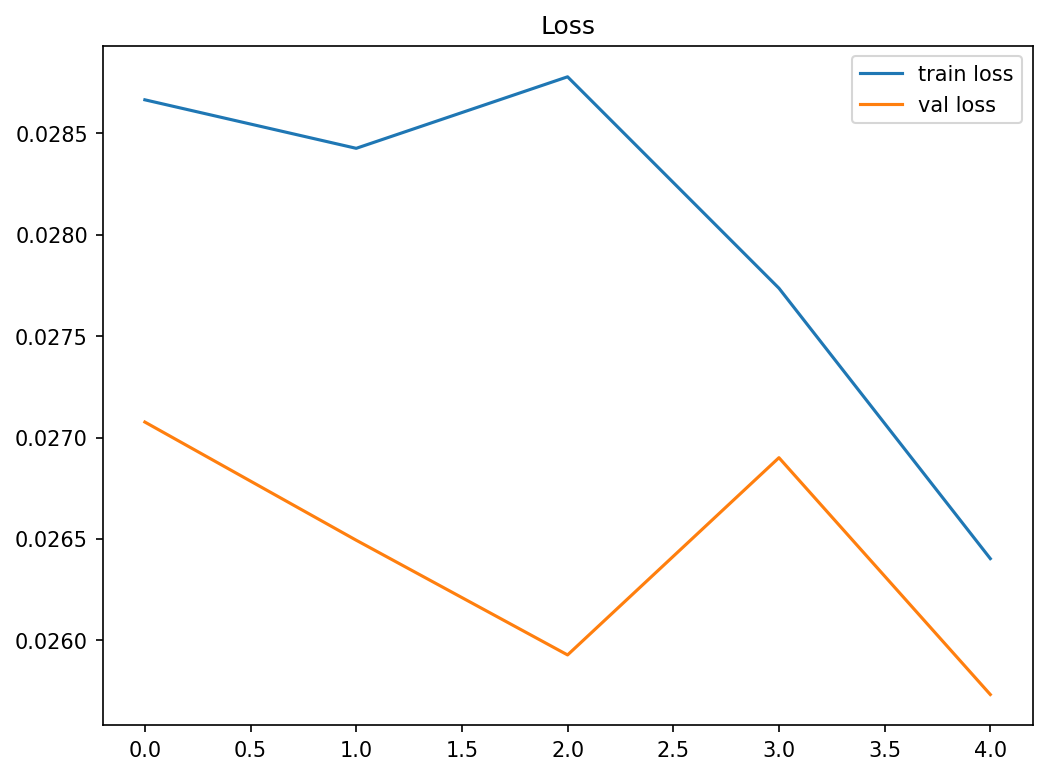

In [15]:
plt.figure(figsize=(8, 6), dpi=150)
plt.plot(log["loss"], label="train loss")
plt.plot(log["val_loss"], label="val loss")
plt.legend()
plt.title("Loss")
plt.show()

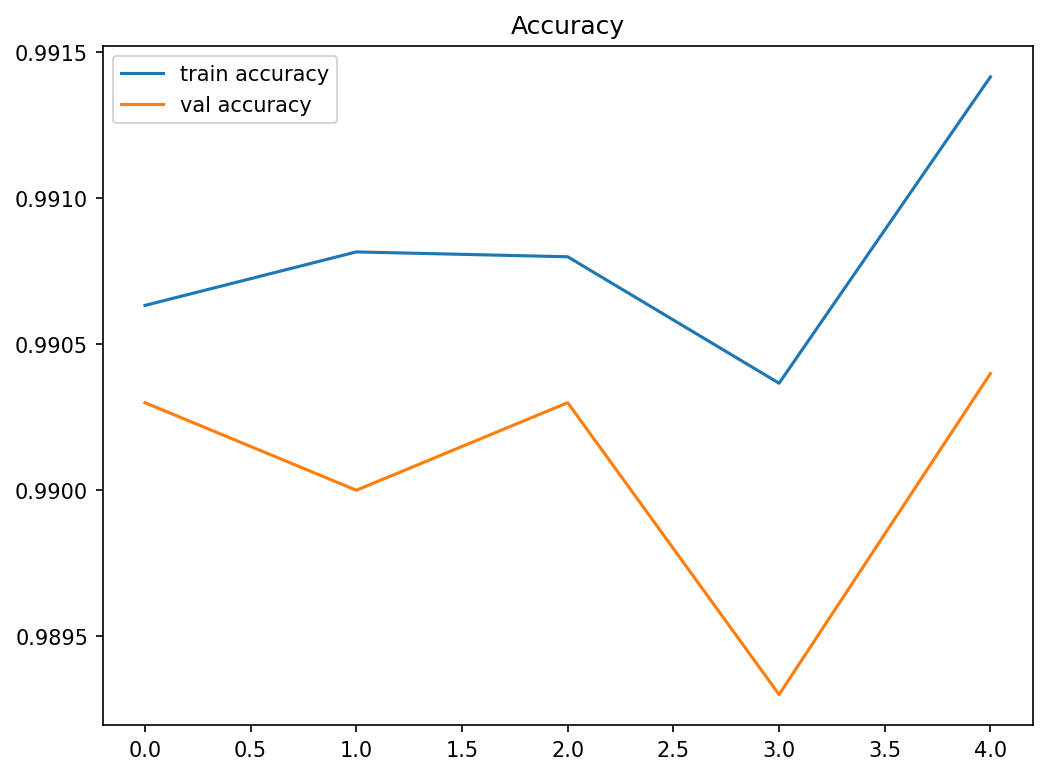

In [16]:
plt.figure(figsize=(8, 6), dpi=150)
plt.plot(log["accuracy"], label="train accuracy")
plt.plot(log["val_accuracy"], label="val accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()